In [1]:

import sys
import scanpy as sc
import os
sys.path.append(os.path.abspath("../.."))

os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import torch
import src.FRLC as FRLC
import src.FRLC.FRLC_multimarginal as FRLC_multimarginal
import src.HiddenMarkovOT

import src.utils.util_LR as util_LR
from src.utils.util_LR import convert_adata


idxs = [1]

In [2]:
import random
import numpy as np

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return

seed_everything(42)

In [3]:
import pandas as pd
import importlib

import src.utils.clustering
import src.HiddenMarkovOT as HiddenMarkovOT
import src.plotting as plotting

import pickle
import numpy as np
import differentiation_map_validation as dmv
importlib.reload(dmv)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Filehandle for final differentiation map outputs
diffmap_dir = "/scratch/gpfs/ph3641/hm_ot/ME_unsupervised_diffmap/"
os.makedirs(diffmap_dir, exist_ok=True)


# Cell-type labels for all timepoints + replicates
df_cell = pd.read_csv("/scratch/gpfs/ph3641/hm_ot/df_cell.csv")
df_cell = df_cell.set_index("cell_id")

edge_dir = "/scratch/gpfs/ph3641/hm_ot/edges.txt"
node_dir = "/scratch/gpfs/ph3641/hm_ot/nodes.txt"

# Load the data
nodes_df = pd.read_csv(node_dir, sep="\t")
edges_df = pd.read_csv(edge_dir, sep="\t")
G, labels_G = dmv.yield_differentiation_graph(nodes_df, edges_df, plotting=False)

diffmap_dir = "/scratch/gpfs/ph3641/hm_ot/ME_supervised_diffmap/"
diffmap_dir_moscot = "/scratch/gpfs/ph3641/hm_ot/ME_supervised_diffmap_moscot/"


In [ ]:
import os
import numpy as np
import pickle
import importlib
importlib.reload(plotting)

timepoints =  ['E8.5', 'E8.75', 'E9.0', 'E9.25', 'E9.5', 'E9.75']
replicates = ['embryo_11', 'embryo_14', 'embryo_16', 'embryo_20', 'embryo_24', 'embryo_28']

_Ts = []
_Ts_m = []

_labels = []

for i in range(len(timepoints) - 1):
    
    t1 = timepoints[i]
    t2 = timepoints[i + 1]
    print(f'loading {t1} to {t2}')
    
    # Load T matrices (diff map for HM-OT supervised)
    T12 = np.load(os.path.join(diffmap_dir, f"{t1}_{t2}_T.npy"))
    _Ts.append(T12)
    
    #  Load T matrices (moscot)
    T12 = np.load(os.path.join(diffmap_dir_moscot, f"{t1}_{t2}_T.npy"))
    _Ts_m.append(T12)
    
    # Load labels
    with open(os.path.join(diffmap_dir, f"{t1}_types.pkl"), 'rb') as f:
        Label_t1 = pickle.load(f)
    with open(os.path.join(diffmap_dir, f"{t2}_types.pkl"), 'rb') as f:
        Label_t2 = pickle.load(f)
    
    if i == 0:
        _labels.append(Label_t1)
    _labels.append(Label_t2)


In [5]:


def score_triples(Qs, Ts, labels, times, G, labels_G, edges_df):
    T13 = Ts[0] @ np.diag( 1/ np.sum(Qs[1], axis=0) ) @ Ts[1]
    edge_scores, diagonal_edge_scores = dmv.score_from_graph([Qs[0], Qs[2]], [T13], [labels[0], labels[2]],[times[0], times[2]],
                                 G, labels_G, edges_df,
                                )
    npmis = []
    diagonal_npmis = []
    
    for key in edge_scores:
        npmis.append(edge_scores[key])
    for key in diagonal_edge_scores:
        diagonal_npmis.append(diagonal_edge_scores[key])
    
    print(f'Median NPMI (off-diagonal): {np.median(npmis)}')
    print(f'Median NPMI (diagonal): {np.median(diagonal_npmis)}')
    print(f'Mean NPMI (off-diagonal): {np.mean(npmis)}')
    print(f'Mean NPMI (diagonal): {np.mean(diagonal_npmis)}')
    
    return edge_scores, diagonal_edge_scores

def merge_dicts_of_lists(dict1, dict2):
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged:
            merged[key].extend(value)
        else:
            merged[key] = value.copy()
    return merged


In [6]:

filehandle_ME = f'/scratch/gpfs/ph3641/hm_ot/adata_JAX_dataset_1.h5ad'
sys.path.insert(0, filehandle_ME)
adata = sc.read_h5ad(filehandle_ME, backed="r")

save_dir = '/scratch/gpfs/ph3641/mouse_embryo/SC_pca_pairs/'
os.makedirs(save_dir, exist_ok=True)


for i in range(1, len(timepoints) - 1):
    t1, t2, t3 = timepoints[i-1], timepoints[i], timepoints[i+1]
    r1, r2, r3 = replicates[i-1], replicates[i], replicates[i+1]
    
    fname = f"{save_dir}/subset_{t1}_{t2}_{t3}_r{r1}{r2}{r3}.h5ad"
    if not os.path.exists(fname):
        subset_adata = adata[
            (adata.obs['day'].isin([t1, t2, t3])) &
            (adata.obs['embryo_id'].isin([r1, r2, r3]))
        ]
        subset_adata = subset_adata.to_memory()
        subset_adata.obs = subset_adata.obs.set_index("cell_id")
        subset_adata.obs = subset_adata.obs.join(df_cell[['celltype_update']], how="left")
        print('-----Starting PCA!-----')
        sc.pp.normalize_total(subset_adata, target_sum=1e4)
        sc.pp.log1p(subset_adata)
        sc.pp.pca(subset_adata, n_comps=30)
        print('-----PCA done!-----')
        subset_adata.write(fname, compression="gzip")
        print("Wrote", fname)



In [7]:
import src.utils.clustering as clustering
import differentiation_map_validation as dmv
from src.FRLC.FRLC_multimarginal import FRLC_LR_opt_multimarginal
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import adjusted_rand_score as ari
import copy

"""
Loading file / AnnData
"""

filehandle_ME = f'/scratch/gpfs/ph3641/hm_ot/adata_JAX_dataset_1.h5ad'
sys.path.insert(0, filehandle_ME)
adata = sc.read_h5ad(filehandle_ME, backed="r")

moscot_diag = {}
moscot_offdiag = {}
hmot_s_diag = {}
hmot_s_offdiag = {}
hmot_u_diag = {}
hmot_u_offdiag = {}

seed_everything(42)


In [8]:

def evaluate_i(i, device, timepoints, replicates,
                    running_min_cost = torch.inf, num_iter = 3):
    
    gen = torch.Generator(device=device)
    gen.manual_seed(i + 42)
    
    t1, t2, t3 = timepoints[i-1], timepoints[i], timepoints[i+1]
    r1, r2, r3 = replicates[i-1], replicates[i], replicates[i+1]
    
    fname = f"{save_dir}/subset_{t1}_{t2}_{t3}_r{r1}{r2}{r3}.h5ad"
    
    print(f'Evaluation of {t1}_{t2}_{t3}; {r1}{r2}{r3}')
    
    subset_adata = sc.read_h5ad(fname)
    r_max = 150
    C_factors_sequence, A_factors_sequence, Qs, labels, rank_list, _spatial_list = convert_adata(subset_adata,
                                                                                                 timepoints=[t1, t2, t3],
                                                                                                 replicates=[r1, r2, r3],
                                                                                                 timepoint_key = 'day',
                                                                                                 replicate_key = 'embryo_id',
                                                                                                 feature_key = 'X_pca',
                                                                                                cell_type_key = 'celltype_update',
                                                                                                spatial = False,
                                                                                                dist_eps = 0.02,
                                                                                                dist_rank = r_max, 
                                                                                                device = device)
    
    proportions = [torch.sum(torch.tensor(Qs[i]).to(torch.float32), axis=0) for i in range(len(Qs))]
    
    # Annotation types
    Qs_ann = [Q.cpu().numpy() for Q in Qs]
    
    """
    Supervised HM-OT
    """
    hmot_sup = HiddenMarkovOT.HM_OT(rank_list, 
                                tau_in = 1e-3,
                                tau_out = 1e-3,
                                gamma= 7,
                                max_iter= 20,
                                min_iter= 20,
                                device=device,
                                dtype=torch.float32,
                                printCost=False,
                                returnFull=False,
                                alpha=0.0,
                                initialization='Full',
                                generator=gen
                               )
    
    hmot_sup.impute_annotated_transitions(C_factors_sequence, 
                                     A_factors_sequence, 
                                     copy.deepcopy(Qs))
    """
    Unsupervised HM-OT
    """
    for j in range(num_iter):
        
        # Set a replicable random seed
        gen_u = torch.Generator(device=device)
        gen_u.manual_seed(i + j + 42)
        
        # Initialize HM-OT
        hmot = HiddenMarkovOT.HM_OT(
                                    rank_list, 
                                    tau_in = 1e-3,
                                    tau_out = 1e-3,
                                    gamma= 80,
                                    max_iter= 50,
                                    min_iter= 50,
                                    device=device,
                                    dtype=torch.float32,
                                    printCost=False,
                                    returnFull=False,
                                    alpha=0.0,
                                    initialization='Full',
                                    proportions = proportions,
                                    max_inner_iters_B = 200,
                                    max_inner_iters_R = 200,
                                    generator=gen_u
                                   )
        
        hmot.gamma_smoothing(C_factors_sequence, A_factors_sequence, 
                             Qs_freeze = [False, False, False],
                             Qs_IC = [Qs[0], Qs[1], Qs[2]], 
                             warmup = True
                            )
        
        if hmot.compute_total_cost(C_factors_sequence, A_factors_sequence) < running_min_cost:
            hmot = hmot
            
    '''
    hmot = HiddenMarkovOT.HM_OT(
                                rank_list, 
                                tau_in = 1e-3,
                                tau_out = 1e-3,
                                gamma= 80,
                                max_iter= 50,
                                min_iter= 50,
                                device=device,
                                dtype=torch.float32,
                                printCost=False,
                                returnFull=False,
                                alpha=0.0,
                                initialization='Full',
                                proportions = proportions,
                                max_inner_iters_B = 200,
                                max_inner_iters_R = 200,
                                generator=gen
                               )
    
    hmot.gamma_smoothing(C_factors_sequence, A_factors_sequence, 
                         Qs_freeze = [False, False, False],
                         Qs_IC = [Qs[0], Qs[1], Qs[2]], 
                         warmup = True)
    '''
    # Unsupervised types and transitions
    Qs_u = [Q_.cpu().numpy() for Q_ in hmot.Q_gammas]
    Ts = [T.cpu().numpy() for T in hmot.T_gammas]
    
    # Moscot and hmot supervised transitions
    Ts_m = [T for T in _Ts_m[i-1:i+1]]
    Ts_s = [T.cpu().numpy() for T in hmot_sup.T_gammas]
    
    # Datasets for PCA expression at 3 timepoints
    X1 = subset_adata[subset_adata.obs['day'] == t1].obsm['X_pca']
    X2 = subset_adata[subset_adata.obs['day'] == t2].obsm['X_pca']
    X3 = subset_adata[subset_adata.obs['day'] == t3].obsm['X_pca']
    
    dmv.evaluate_coclusters(Qs_ann, Qs_u, [T.cpu().numpy() for T in hmot.T_gammas], 
                        [T.cpu().numpy() for T in hmot_sup.T_gammas], Ts_m,
                            X1, X2, X3)
    return



In [22]:
seed_everything(42)
evaluate_i(1, device, timepoints, replicates, num_iter = 5)

Evaluation of E8.5_E8.75_E9.0; embryo_11embryo_14embryo_16
Computing low-rank distance matrix!
Computing low-rank distance matrix!


/tmp/ipykernel_695052/330636314.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proportions = [torch.sum(torch.tensor(Qs[i]).to(torch.float32), axis=0) for i in range(len(Qs))]


Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Ranks: r1 46, r2 55, r3 59
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Final Cost: 0.0; cost_GW: 0, cost_W: 2.1769352986922286e-10
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Ranks: r1 46, r2 55, r3 59
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Final Cost: 0.0; cost_GW: 0, cost_W: 2.178427715993081e-10
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Ranks: r1 46, r2 55, r3 59
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Final Cost: 0.0; cost_GW: 0, cost_W: 2.187266479047878e-10
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Ranks: r1 46, r2 55, r3 59
Iteration: 0
Iter

In [9]:
seed_everything(42)
evaluate_i(2, device, timepoints, replicates, num_iter = 5)

Evaluation of E8.75_E9.0_E9.25; embryo_14embryo_16embryo_20
Computing low-rank distance matrix!
Computing low-rank distance matrix!


/tmp/ipykernel_779266/330636314.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proportions = [torch.sum(torch.tensor(Qs[i]).to(torch.float32), axis=0) for i in range(len(Qs))]


Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Ranks: r1 55, r2 59, r3 68
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Final Cost: 0.0; cost_GW: 0, cost_W: 9.426954356017703e-11
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Ranks: r1 55, r2 59, r3 68
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Final Cost: 0.0; cost_GW: 0, cost_W: 9.41011366051292e-11
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Ranks: r1 55, r2 59, r3 68
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Final Cost: 0.0; cost_GW: 0, cost_W: 9.354507446435179e-11
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Ranks: r1 55, r2 59, r3 68
Iteration: 0
Iterat

In [10]:
seed_everything(42)
evaluate_i(3, device, timepoints, replicates, num_iter = 5)

Evaluation of E9.0_E9.25_E9.5; embryo_16embryo_20embryo_24
Computing low-rank distance matrix!
Computing low-rank distance matrix!


/tmp/ipykernel_779266/330636314.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proportions = [torch.sum(torch.tensor(Qs[i]).to(torch.float32), axis=0) for i in range(len(Qs))]


Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Ranks: r1 59, r2 68, r3 81
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Final Cost: 0.0; cost_GW: 0, cost_W: 3.5910191487076304e-11
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Ranks: r1 59, r2 68, r3 81
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Final Cost: 0.0; cost_GW: 0, cost_W: 3.5781259899447804e-11
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Ranks: r1 59, r2 68, r3 81
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Final Cost: 0.0; cost_GW: 0, cost_W: 3.596233033587026e-11
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Ranks: r1 59, r2 68, r3 81
Iteration: 0
Ite

In [11]:
seed_everything(42)
evaluate_i(4, device, timepoints, replicates, num_iter = 5)

Evaluation of E9.25_E9.5_E9.75; embryo_20embryo_24embryo_28
Computing low-rank distance matrix!
Computing low-rank distance matrix!


/tmp/ipykernel_779266/330636314.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proportions = [torch.sum(torch.tensor(Qs[i]).to(torch.float32), axis=0) for i in range(len(Qs))]


Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Ranks: r1 68, r2 81, r3 90
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Final Cost: 0.0; cost_GW: 0, cost_W: 1.2879509958541036e-11
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Ranks: r1 68, r2 81, r3 90
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Final Cost: 0.0; cost_GW: 0, cost_W: 1.2979686769831744e-11
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Ranks: r1 68, r2 81, r3 90
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Final Cost: 0.0; cost_GW: 0, cost_W: 1.289991551078895e-11
Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Iteration: 0
Iteration: 25
Ranks: r1 68, r2 81, r3 90
Iteration: 0
Ite

/tmp/ipykernel_1213880/2766335234.py:100: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) DejaVu Serif.
  plt.tight_layout()
/tmp/ipykernel_1213880/2766335234.py:101: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) DejaVu Serif.
  plt.savefig('sc_Supervised_Unsupervised_Cosine.svg')
/home/ph3641/.conda/envs/peterenv2/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) DejaVu Serif.
  fig.canvas.print_figure(bytes_io, **kw)


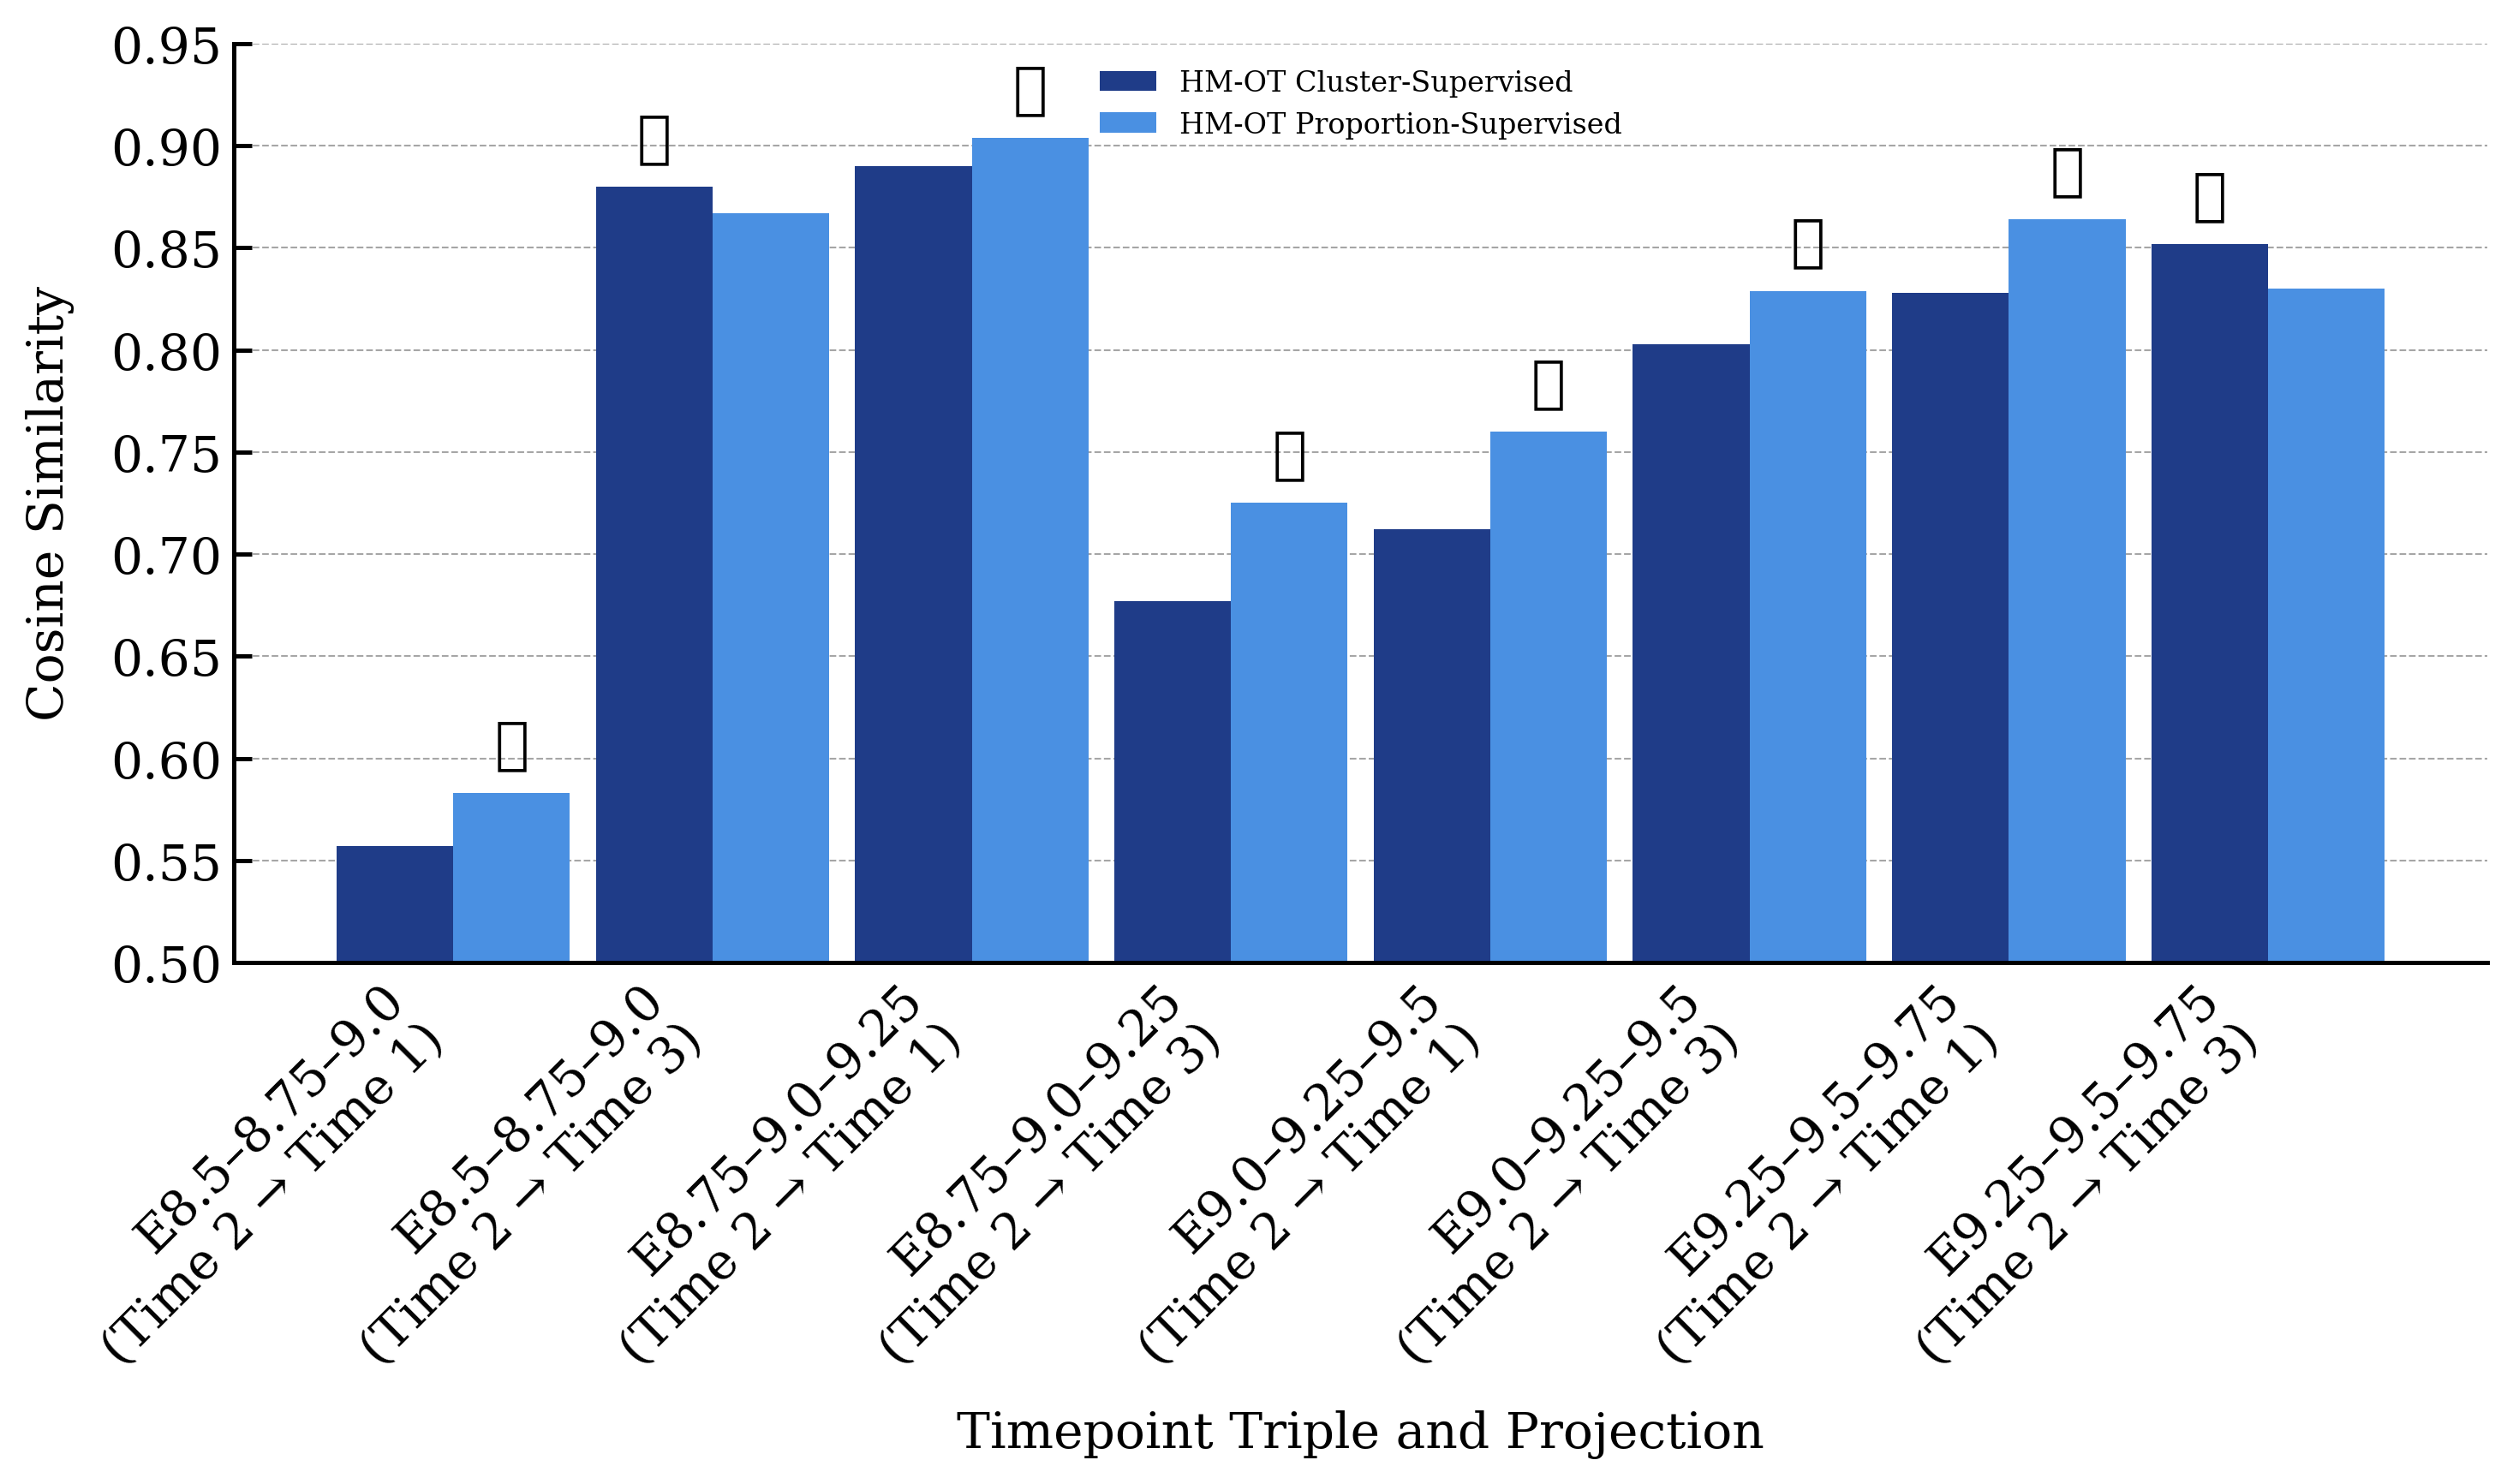

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Publication-style settings
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# Data
triples = [
    'E8.5–8.75–9.0',
    'E8.75–9.0–9.25',
    'E9.0–9.25–9.5',
    'E9.25–9.5–9.75'
]

# Cosine similarities for projections of t2 → t1
hmot_t1_s = [0.557, 0.890, 0.712, 0.828]
hmot_t1_u = [0.583, 0.904, 0.760, 0.864]
moscot_t1 = [0.518, 0.886, 0.677, 0.824]

# Cosine similarities for projections of t2 → t3
hmot_t3_s = [0.880, 0.677, 0.803, 0.852]
hmot_t3_u = [0.867, 0.725, 0.829, 0.830]
moscot_t3 = [0.869, 0.631, 0.769, 0.846]

# Compute gains
t1_s = np.array(hmot_t1_s)
t1_u = np.array(hmot_t1_u)
t3_s = np.array(hmot_t3_s)
t3_u = np.array(hmot_t3_u)

# Prepare for 8 pairs
values_sup = []
values_unsup = []
labels = []

for i, triple in enumerate(triples):
    values_sup.append(t1_s[i])
    values_unsup.append(t1_u[i])
    labels.append(f"{triple}\n(Time 2 → Time 1)")
    values_sup.append(t3_s[i])
    values_unsup.append(t3_u[i])
    labels.append(f"{triple}\n(Time 2 → Time 3)")

values_sup = np.array(values_sup)
values_unsup = np.array(values_unsup)
x = np.arange(len(values_sup))
width = 0.45

# Create figure
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Bars with light & dark orange
#light_orange = '#ffcc80'
#dark_orange = '#ff8f00'
color1 = '#1f3c88'  # deep navy blue
color2 = '#4a90e2'  # medium-light sky blue

bars_sup = ax.bar(x - width/2, values_sup, width, label='HM‑OT Cluster-Supervised', color=color1, edgecolor='none')
bars_unsup = ax.bar(x + width/2, values_unsup, width, label='HM‑OT Proportion-Supervised', color=color2, edgecolor='none')

# Add stars for best of each pair
for idx in range(len(x)):
    if values_sup[idx] > values_unsup[idx]:
        star_x = x[idx] - width/2
        star_y = values_sup[idx]
    else:
        star_x = x[idx] + width/2
        star_y = values_unsup[idx]
    ax.text(star_x, star_y + 0.01, '★', ha='center', va='bottom', fontsize=16)

# Styling
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylim(0.5, 0.95)
ax.set_xlabel('Timepoint Triple and Projection', labelpad=10)
ax.set_ylabel('Cosine Similarity', labelpad=10)
ax.axhline(0, linestyle='--', color='gray', linewidth=0.8)

# Thicken bottom & left spines, remove top/right
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.2)
ax.spines['left'].set_linewidth(1.2)

# Ticks styling
ax.xaxis.set_tick_params(width=1.2, length=5)
ax.yaxis.set_tick_params(width=1.2, length=5)

# Grid
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax.set_axisbelow(True)

# Legend
ax.legend(frameon=False, loc='upper center', fontsize=8)

plt.tight_layout()
plt.savefig('sc_Supervised_Unsupervised_Cosine.svg')

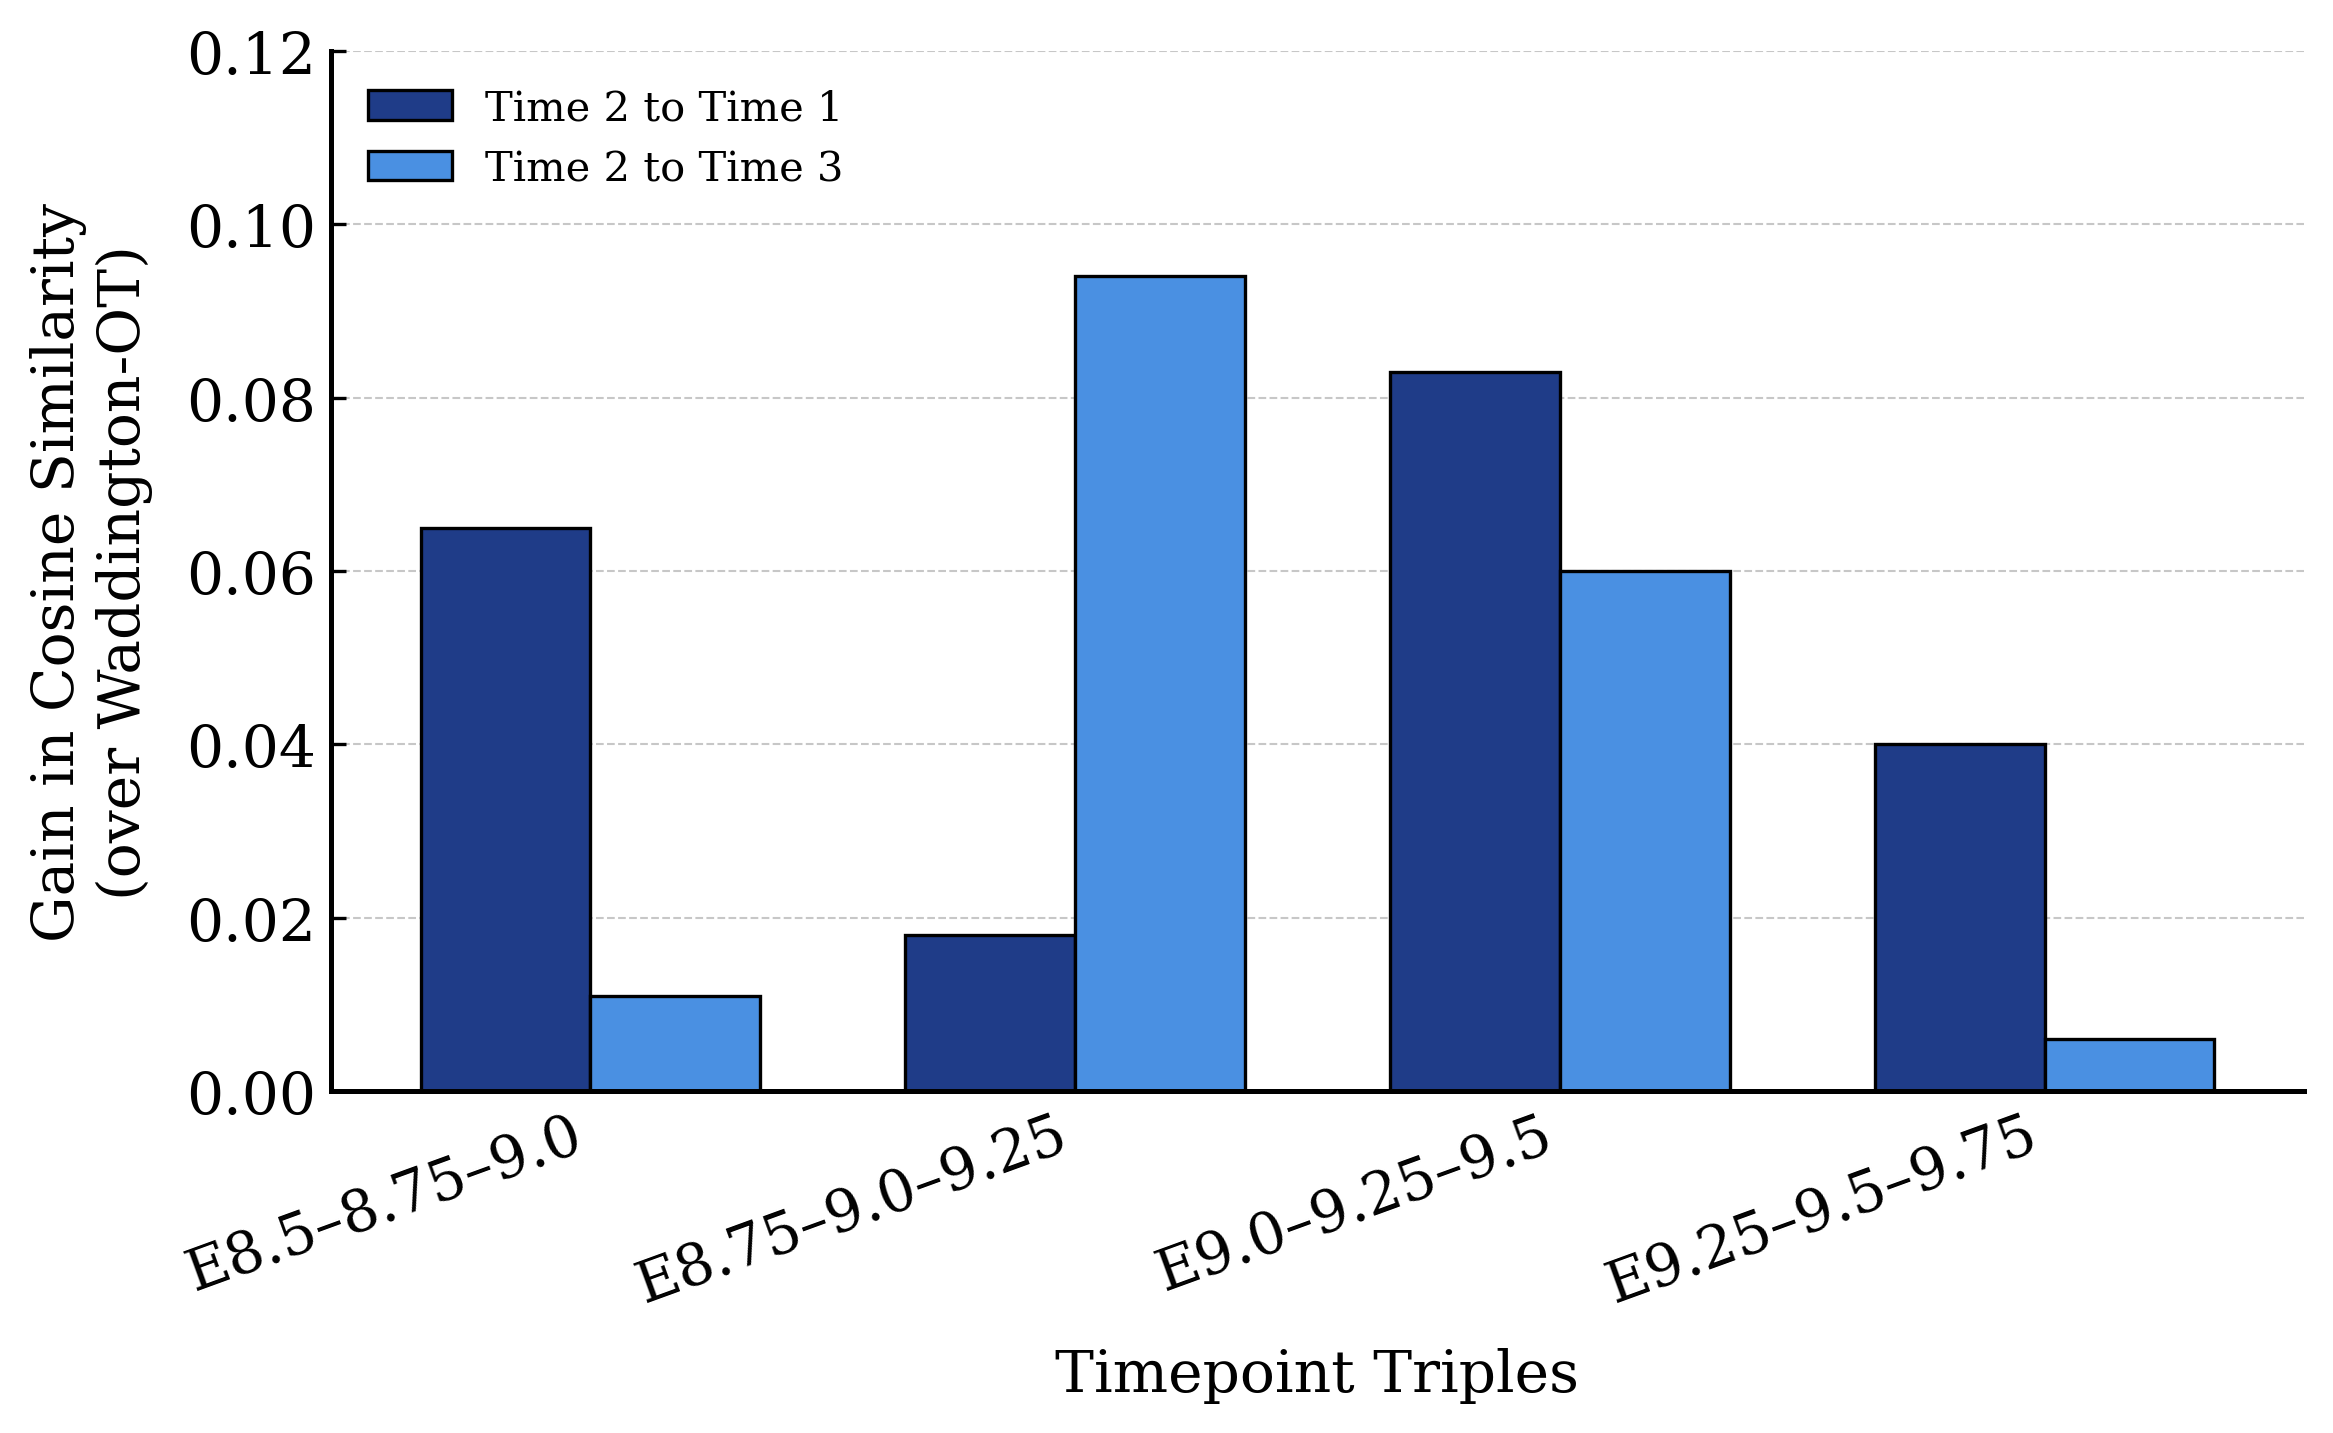

In [7]:
# Compute gains
gain_t1_s = np.array(hmot_t1_s) - np.array(moscot_t1)
gain_t1_u = np.array(hmot_t1_u) - np.array(moscot_t1)
gain_t3_s = np.array(hmot_t3_s) - np.array(moscot_t3)
gain_t3_u = np.array(hmot_t3_u) - np.array(moscot_t3)

# pick the best HM-OT variant vs. moscot
best_gain_t1 = np.maximum(gain_t1_s, gain_t1_u)   # best of sup/unsup for t2→t1
best_gain_t3 = np.maximum(gain_t3_s, gain_t3_u)   # best of sup/unsup for t2→t3

# Plot
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
x = np.arange(len(triples))
width = 0.35

# Colors: blue/green scheme
#color1 = '#1f77b4'  # muted blue
#color2 = '#2ca02c'  # muted green

color1 = '#1f3c88'  # deep navy blue
color2 = '#4a90e2'  # medium-light sky blue

bars1 = ax.bar(x - width/2, best_gain_t1, width, label='Time 2 to Time 1', color=color1, edgecolor='black', linewidth=0.8)
bars2 = ax.bar(x + width/2, best_gain_t3, width, label='Time 2 to Time 3', color=color2, edgecolor='black', linewidth=0.8)

# Axes and grid styling
ax.set_xticks(x)
ax.set_xticklabels(triples, rotation=20, ha='right')
ax.set_ylim(0, 0.12)
ax.set_ylabel('Gain in Cosine Similarity\n(over Waddington-OT)', labelpad=8)
ax.set_xlabel('Timepoint Triples', labelpad=8)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_axisbelow(True)

# Spine styling
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_linewidth(1.2)
ax.spines['left'].set_linewidth(1.2)

# Legend
ax.legend(frameon=False, loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('sc_CosineGain.svg')

In [6]:
best_gain_t1

array([0.065, 0.018, 0.083, 0.04 ])

In [7]:
best_gain_t3

array([0.011, 0.094, 0.06 , 0.006])